# Predicting Credit Card Spend

# Problem Statement:

One of the global banks would like to understand what factors driving credit card spend are. The bank want use these insights to calculate credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data. The objective of to understand what's driving the total spend (Primary Card + Secondary card). Given the factors, predict credit limit for the new applicants

### Importing Libraries 

In [1]:
import pandas as pd
import numpy as np

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.formula.api as smf

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

### Getting Data Imported

In [2]:
data=pd.read_excel("Data Set.xlsx")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
region,5000.0,3.001400,1.421760,1.0,2.0,3.0,4.0,5.0
townsize,4998.0,2.687275,1.425925,1.0,1.0,3.0,4.0,5.0
gender,5000.0,0.503600,0.500037,0.0,0.0,1.0,1.0,1.0
age,5000.0,47.025600,17.770338,18.0,31.0,47.0,62.0,79.0
agecat,5000.0,4.238800,1.308785,2.0,3.0,4.0,5.0,6.0
...,...,...,...,...,...,...,...,...
ownfax,5000.0,0.178800,0.383223,0.0,0.0,0.0,0.0,1.0
news,5000.0,0.472600,0.499299,0.0,0.0,0.0,1.0,1.0
response_01,5000.0,0.083600,0.276815,0.0,0.0,0.0,0.0,1.0
response_02,5000.0,0.129800,0.336117,0.0,0.0,0.0,0.0,1.0


### Generating Profile Report for Data Understanding

In [5]:
# profile_report=ProfileReport(data)

In [6]:
# profile_report.to_file('profile_report.html')

### Target variable = cardspent + card2spent

In [7]:
Y=data['cardspent']+data['card2spent']

In [8]:
Y.name='Card_Spend'

In [9]:
Y.head()

0    149.46
1     77.54
2    359.97
3    359.41
4    507.83
Name: Card_Spend, dtype: float64

In [10]:
#removing extra column
data.drop(columns=['card2spent','cardspent'],inplace=True)

In [11]:
#Checking for duplicate records
data.duplicated().sum()

0

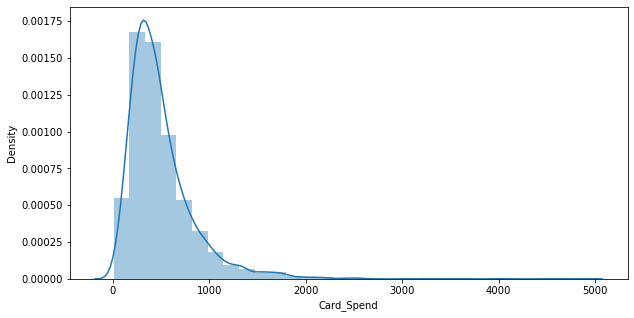

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(Y,bins=30)
plt.show()

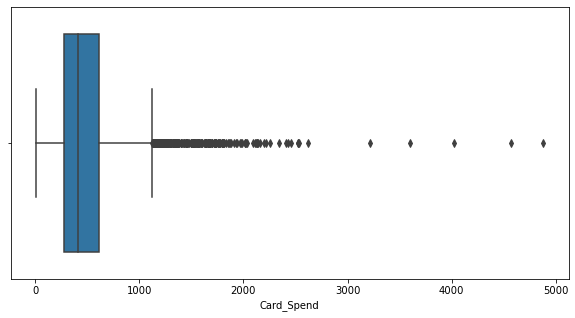

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(Y)
plt.show()

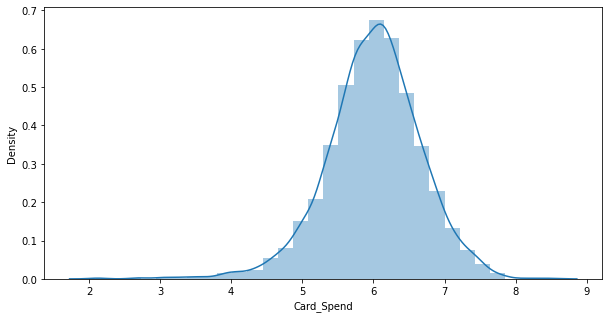

In [14]:
plt.figure(figsize=(10,5))
sns.distplot(np.log(Y),bins=30)
plt.show()

In [15]:
Y=np.log(Y)
Y.name='Log_card_spend'

In [16]:
#Removing outliers from our Y variable

In [17]:
q1=Y.quantile(0.25)
q3=Y.quantile(0.75)
iqr=q3-q1
lower=q1-(1.5*iqr)
upper=q3+(1.5*iqr)

In [18]:
Y.clip(lower=lower,upper=upper,inplace=True)

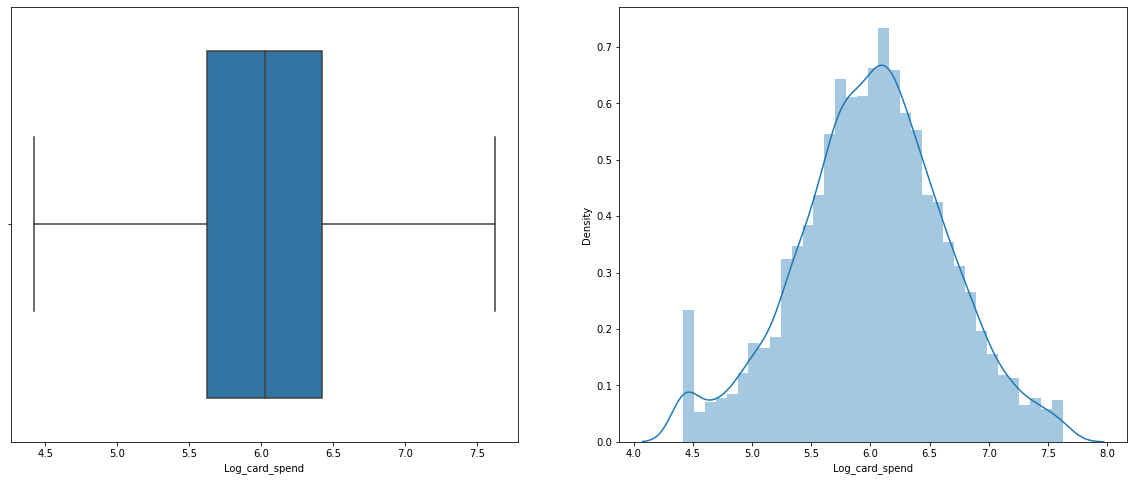

In [19]:
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
sns.boxplot(Y)
plt.subplot(1, 2, 2)
sns.distplot(Y)
plt.show()

### Dropping features based on high cardinality, high missings > 25% and unwanted features

In [20]:
data.drop(columns=['custid','empcat','addresscat','commutecat','cardtenurecat','card2tenurecat','lnwireten','lnequipten','lnwiremon','lnlongten','lntollmon','lnothdebt','lncreddebt','birthmonth','lninc','lnequipmon','lncardmon','lnlongmon','lntollten','lncardten'],inplace=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 108 entries, region to response_03
dtypes: float64(16), int64(92)
memory usage: 4.1 MB


### Handling Missings

In [22]:
missings_cols=list(data.columns[data.isnull().sum()>0])

In [23]:
missings_cols

['townsize', 'commutetime', 'longten', 'cardten']

In [24]:
data[missings_cols].describe()

,townsize,commutetime,longten,cardten
count,4998.000000,4998.000000,4997.000000,4998.000000
mean,2.687275,25.345538,708.871753,720.478391
std,1.425925,5.879149,979.291072,922.225527
min,1.000000,8.000000,0.900000,0.000000
25%,1.000000,21.000000,104.600000,0.000000
50%,3.000000,25.000000,350.000000,425.000000
75%,4.000000,29.000000,913.850000,1080.000000
max,5.000000,48.000000,13046.500000,13705.000000


In [25]:
cat_missing=['townsize']
cont_missing=['commutetime','longten','cardten']

In [26]:
def missing_impute_cat(df,x):
    for i in x:
        df[i].fillna(int(df[i].mode()),inplace=True)

In [27]:
def missing_impute_cont(df,x):
    for i in x:
        df[i].fillna(df[i].median(),inplace=True)

In [28]:
missing_impute_cont(data,cont_missing)

In [29]:
missing_impute_cat(data,cat_missing)

In [30]:
data.columns[data.isnull().sum()>0]

Index([], dtype='object')

### Dropping Features based in low CV

In [31]:
def cv(df,x):
    low_cv=[]
    for i in x:
        if (np.std(df[i])/np.mean(df[i]))<0.05:
            low_cv.append(i)
    return low_cv

In [32]:
low_coefvar=cv(data,data.columns.to_list())

In [33]:
#No feature found with CV<0.05
low_coefvar

[]

### Outlier Treatment

In [34]:
data.shape

(5000, 108)

In [35]:
data.dtypes.value_counts()

int64      92
float64    16
dtype: int64

In [36]:
cat_vars='''region
townsize
gender
agecat
edcat
jobcat
union
retire
inccat
default
jobsat
marital
spousedcat
homeown
hometype
cars
carown
cartype
carcatvalue
carbought
carbuy
commute
commutecar
commutemotorcycle
commutecarpool
commutebus
commuterail
commutepublic
commutebike
commutewalk
commutenonmotor
telecommute
reason
polview
polparty
polcontrib
vote
card
cardtype
cardbenefit
cardfee
card2
card2type
card2benefit
card2fee
active
bfast
churn
tollfree
equip
callcard
wireless
multline
voice
pager
internet
callid
callwait
forward
confer
ebill
owntv
ownvcr
owndvd
owncd
ownpda
ownpc
ownipod
owngame
ownfax
news
response_01
response_02
response_03'''.split('\n')

In [37]:
len(cat_vars)

74

In [38]:
data_cat=data[cat_vars]

In [39]:
data_cont=data.drop(columns=cat_vars)

In [40]:
data_cont.shape

(5000, 34)

In [41]:
def outlier(df,x):
    for i in x:
        q1=df[i].quantile(0.25)
        q3=df[i].quantile(0.75)
        iqr=q3-q1
        lower=q1-(1.5*iqr)
        upper=q3+(1.5*iqr)
        df[i].clip(lower=lower,upper=upper,inplace=True)

In [42]:
outlier(data_cont,data_cont.columns)

In [43]:
del data

#### Dummy Variable Creation

In [44]:
data_cat.dtypes=='object'

region         False
townsize       False
gender         False
agecat         False
edcat          False
               ...  
ownfax         False
news           False
response_01    False
response_02    False
response_03    False
Length: 74, dtype: bool

In [45]:
data_cat=data_cat.astype('object')

In [46]:
data_cat=pd.get_dummies(data=data_cat,drop_first=True)

In [47]:
data_cat

,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,agecat_3,...,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,1,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0,0,...,1,1,1,1,1,1,1,0,0,0
2,0,1,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,1,1,1,0,1,1,0,0
4,1,0,0,0,1,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4996,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4997,0,0,1,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,0,0
4998,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,0,1,0,0,0


In [48]:
data_cont.head(5)

,age,ed,employ,income,debtinc,creddebt,othdebt,spoused,reside,pets,...,longten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,hourstv
0,20,15,0.0,31.0,11.1,1.200909,2.240091,-1,3,0.0,...,34.40,29.0,161.05,29.50,126.10000,14.25,60.0,0.00,0.00000,13
1,22,17,0.0,15.0,18.6,1.222020,1.567980,-1,2,6.0,...,330.60,0.0,0.00,54.85,1275.40625,16.00,610.0,45.65,224.90625,18
2,67,14,16.0,35.0,9.9,0.928620,2.536380,13,3,3.0,...,1858.35,0.0,0.00,0.00,0.00000,23.00,1410.0,0.00,0.00000,21
3,23,16,0.0,20.0,5.7,0.022800,1.117200,18,5,0.0,...,199.45,0.0,0.00,0.00,0.00000,21.00,685.0,0.00,0.00000,26
4,26,16,1.0,23.0,1.7,0.214659,0.176341,13,4,0.0,...,74.10,16.5,387.70,0.00,0.00000,17.25,360.0,19.05,224.90625,27


#### Merging Catagorical and Numerical Vars

In [49]:
data=pd.concat([data_cont,data_cat],axis=1)

In [50]:
data.shape

(5000, 182)

### Feature Engineering (Y-X Relationship)

#### Correlation Matix

In [51]:
corr_mat=pd.concat([Y,data],axis=1).corr()

In [52]:
corr_mat.to_excel('Corr_Matrix.xlsx')

In [53]:
#Based on the correlation Matrix we can pick feature which is influencing my Target Variable(Y=cardspent)

In [54]:
features_corr='''income
carvalue
othdebt
carcatvalue_3
creddebt
inccat_5
retire_1
carcatvalue_1
card2_3'''.split('\n')
features_corr

['income',
 'carvalue',
 'othdebt',
 'carcatvalue_3',
 'creddebt',
 'inccat_5',
 'retire_1',
 'carcatvalue_1',
 'card2_3']

#### Univariate Regression (F-Regression)

In [55]:
f_value, p_value = f_regression(data,Y)

In [56]:
f_regg_score=pd.concat([pd.Series(f_value),pd.Series(p_value)],axis=1)

In [57]:
f_regg_score.set_index(data.columns.difference(['cardspent']),drop=True,inplace=True)
f_regg_score.rename(columns={0:'F_Value',1:'P_Value'},inplace=True)

In [58]:
f_regg_score.to_excel('F_regg_result.xlsx')

In [59]:
f_regg_res='''agecat_3
card2_2
equipmon
agecat_6
forward_1
agecat_5
commute_4
churn_1
commute_3
tollten
edcat_4
tollmon
jobsat_4
townsize_2.0
edcat_5
ownpc_1
ownpda_1
carown_1
commute_2
address
cars_1
card2tenure
equipten
pets_small
tollfree_1
card_3
card_4
carown_0
cardtype_3
cars_6
pets_saltfish
card2fee_1
age
owntv_1
reside
card2type_2
card2type_3
commutepublic_1
townsize_3.0
commute_10
commuterail_1
voice_1
wireten
card2_5
polcontrib_1
card2_4
response_03_1
ownipod_1
card2benefit_2
spousedcat_3
spousedcat_4
polparty_1
spousedcat_2
telecommute_1
cars_4
region_3
carcatvalue_3
region_4
spousedcat_5
cars_5
cars_2
ownvcr_1
commute_9
response_01_1
longmon
spousedcat_1
cars_7
townsize_4.0
response_02_1
card2benefit_3
card2benefit_4
reason_9
union_1
townsize_5.0
confer_1
owncd_1
reason_4
commutebus_1
owngame_1
commute_8
vote_1
card_2
tenure
commutemotorcycle_1
hourstv
bfast_2
polview_6
cardfee_1
cardtype_4
card_5
commutetime
wiremon'''.split('\n')

In [60]:
f_regg_res

['agecat_3',
 'card2_2',
 'equipmon',
 'agecat_6',
 'forward_1',
 'agecat_5',
 'commute_4',
 'churn_1',
 'commute_3',
 'tollten',
 'edcat_4',
 'tollmon',
 'jobsat_4',
 'townsize_2.0',
 'edcat_5',
 'ownpc_1',
 'ownpda_1',
 'carown_1',
 'commute_2',
 'address',
 'cars_1',
 'card2tenure',
 'equipten',
 'pets_small',
 'tollfree_1',
 'card_3',
 'card_4',
 'carown_0',
 'cardtype_3',
 'cars_6',
 'pets_saltfish',
 'card2fee_1',
 'age',
 'owntv_1',
 'reside',
 'card2type_2',
 'card2type_3',
 'commutepublic_1',
 'townsize_3.0',
 'commute_10',
 'commuterail_1',
 'voice_1',
 'wireten',
 'card2_5',
 'polcontrib_1',
 'card2_4',
 'response_03_1',
 'ownipod_1',
 'card2benefit_2',
 'spousedcat_3',
 'spousedcat_4',
 'polparty_1',
 'spousedcat_2',
 'telecommute_1',
 'cars_4',
 'region_3',
 'carcatvalue_3',
 'region_4',
 'spousedcat_5',
 'cars_5',
 'cars_2',
 'ownvcr_1',
 'commute_9',
 'response_01_1',
 'longmon',
 'spousedcat_1',
 'cars_7',
 'townsize_4.0',
 'response_02_1',
 'card2benefit_3',
 'card2ben

#### Multivariate Analysis (RFE)

<AxesSubplot:xlabel='Log_card_spend', ylabel='Density'>

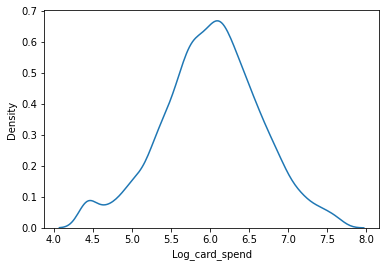

In [61]:
sns.kdeplot(Y)

In [62]:
rfe=RFE(DecisionTreeRegressor(),n_features_to_select=30)

In [63]:
rfe=rfe.fit(data,Y)

In [64]:
rfe_result=data.columns[rfe.support_].tolist()

#### Combining all Results

In [65]:
features_corr

['income',
 'carvalue',
 'othdebt',
 'carcatvalue_3',
 'creddebt',
 'inccat_5',
 'retire_1',
 'carcatvalue_1',
 'card2_3']

In [66]:
rfe_result

['age',
 'ed',
 'employ',
 'income',
 'debtinc',
 'creddebt',
 'othdebt',
 'spoused',
 'pets',
 'pets_freshfish',
 'address',
 'carvalue',
 'commutetime',
 'cardtenure',
 'card2tenure',
 'tenure',
 'longmon',
 'longten',
 'tollmon',
 'equipmon',
 'cardmon',
 'cardten',
 'hourstv',
 'reason_2',
 'card_2',
 'card_3',
 'card_4',
 'card_5',
 'card2_2',
 'card2_3']

In [67]:
f_regg_res

['agecat_3',
 'card2_2',
 'equipmon',
 'agecat_6',
 'forward_1',
 'agecat_5',
 'commute_4',
 'churn_1',
 'commute_3',
 'tollten',
 'edcat_4',
 'tollmon',
 'jobsat_4',
 'townsize_2.0',
 'edcat_5',
 'ownpc_1',
 'ownpda_1',
 'carown_1',
 'commute_2',
 'address',
 'cars_1',
 'card2tenure',
 'equipten',
 'pets_small',
 'tollfree_1',
 'card_3',
 'card_4',
 'carown_0',
 'cardtype_3',
 'cars_6',
 'pets_saltfish',
 'card2fee_1',
 'age',
 'owntv_1',
 'reside',
 'card2type_2',
 'card2type_3',
 'commutepublic_1',
 'townsize_3.0',
 'commute_10',
 'commuterail_1',
 'voice_1',
 'wireten',
 'card2_5',
 'polcontrib_1',
 'card2_4',
 'response_03_1',
 'ownipod_1',
 'card2benefit_2',
 'spousedcat_3',
 'spousedcat_4',
 'polparty_1',
 'spousedcat_2',
 'telecommute_1',
 'cars_4',
 'region_3',
 'carcatvalue_3',
 'region_4',
 'spousedcat_5',
 'cars_5',
 'cars_2',
 'ownvcr_1',
 'commute_9',
 'response_01_1',
 'longmon',
 'spousedcat_1',
 'cars_7',
 'townsize_4.0',
 'response_02_1',
 'card2benefit_3',
 'card2ben

In [68]:
final_features=f_regg_res+rfe_result+features_corr

In [69]:
len(list(set(final_features)))

111

In [70]:
final_features=list(set(final_features))

In [71]:
data_final=data[final_features]

### Feature Engineering (X-X Relationship)

In [72]:
data_final.shape

(5000, 111)

In [73]:
data_lr=data_final[
 [
#  'cars_6',
#  'union_1',
 'card_4',
#  'commute_9',
#  'spousedcat_3',
#  'longten',
#  'tollfree_1',
#  'forward_1',
#  'churn_1',
#  'ownipod_1',
#  'agecat_6',
 'card_5',
#  'agecat_3',
#  'edcat_4',
 'age',
#  'commuterail_1',
#  'pets_small',
#  'carown_1',
#  'wireten',
#  'employ',
#  'ownpc_1',
 'income',
#  'townsize_3.0',
#  'edcat_5',
 'creddebt',
#  'reason_4',
#  'cardtype_3',
#  'region_4',
#  'card2tenure',
#  'pets_freshfish',
#  'townsize_5.0',
#  'equipmon',
#  'polparty_1',
#  'carcatvalue_3',
#  'equipten',
#  'owncd_1',
#  'confer_1',
#  'voice_1',
#  'pets',
#  'telecommute_1',
#  'vote_1',
#  'agecat_5',
#  'spousedcat_1',
 'card_2',
#  'cardten',
#  'tenure',
#  'commute_10',
#  'tollten',
#  'pets_saltfish',
#  'jobsat_4',
#  'cardfee_1',
#  'spousedcat_5',
#  'tollmon',
#  'card2benefit_2',
#  'cars_1',
#  'spousedcat_4',
#  'polcontrib_1',
#  'cars_7',
#  'address',
#  'card2type_2',
  'ed',
#  'region_3',
#  'cardtype_4',
#  'commutepublic_1',
#  'cars_5',
#  'ownvcr_1',
#  'commute_3',
 'card2_2',
#  'card2benefit_4',
#  'cardtenure',
 'othdebt',
#  'spousedcat_2',
#  'response_03_1',
#  'card2benefit_3',
#  'response_01_1',
#  'commutemotorcycle_1',
#  'commute_8',
#  'retire_1',
#  'card2type_3',
#  'carcatvalue_1',
#  'owngame_1',
#  'owntv_1',
#  'longmon',
#  'commutebus_1',
#  'carvalue',
#  'card2fee_1',
#  'inccat_5',
#  'commute_4',
#  'reason_9',
#  'cars_4',
#   'card2_3',
 'reason_2',
#  'wiremon',
 'card2_5',
#  'ownpda_1',
 'card_3',
#  'commute_2',
 'card2_4',
#  'hourstv',
#  'commutetime',
 'debtinc',
#  'spoused',
#  'response_02_1',
#  'polview_6',
#  'reside',
#  'townsize_4.0',
#  'cardmon',
#  'townsize_2.0',
#  'carown_0',
#  'bfast_2',
#  'cars_2',
 'card2_3'
 ]]

In [74]:
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(data_lr.values, i) for i in range(data_lr.shape[1])]
vif["features"] = data_lr.columns

In [75]:
vif.sort_values(by='VIF_Factor').sort_values('VIF_Factor').tail()

,VIF_Factor,features
2,7.317864,age
8,11.401648,othdebt
6,12.403441,ed
13,13.010300,debtinc
3,15.283435,income


## Model Creation

### 1.Linear Regression

#### Train Test Split for Linear Regression

In [76]:
X_train,X_test,Y_train,Y_test=train_test_split(data_lr,Y,train_size=0.7,random_state=101)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(3500, 15)
(1500, 15)
(3500,)
(1500,)


In [77]:
formula='Log_card_spend~'
for i in X_train.columns:
    formula=formula+str(i)+'+'
formula=formula[:len(formula)-1]

In [78]:
formula

'Log_card_spend~card_4+card_5+age+income+creddebt+card_2+ed+card2_2+othdebt+reason_2+card2_5+card_3+card2_4+debtinc+card2_3'

In [79]:
ols=smf.ols(formula=formula,data=pd.concat([X_train,Y_train],axis=1))

In [80]:
ols=ols.fit()

In [81]:
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:         Log_card_spend   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     113.3
Date:                Thu, 10 Jun 2021   Prob (F-statistic):          1.11e-286
Time:                        14:22:44   Log-Likelihood:                -2649.1
No. Observations:                3500   AIC:                             5330.
Df Residuals:                    3484   BIC:                             5429.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7323      0.066    101.832      0.0

In [82]:
linear_regression_training_score=metrics.r2_score(Y_train,ols.predict(X_train))
linear_regression_testing_score=metrics.r2_score(Y_test,ols.predict(X_test))
print('linear_regression_training_score :',linear_regression_training_score)
print('linear_regression_testing_score :',linear_regression_testing_score)

linear_regression_training_score : 0.3279019896206855
linear_regression_testing_score : 0.32901442570970263


In [83]:
linear_regression_training_mape=metrics.mean_absolute_percentage_error(Y_train,ols.predict(X_train))
linear_regression_testing_mape=metrics.mean_absolute_percentage_error(Y_test,ols.predict(X_test))
print('linear_regression_training_mape :',linear_regression_training_mape)
print('linear_regression_testing_mape :',linear_regression_testing_mape)

linear_regression_training_mape : 0.07027466089577683
linear_regression_testing_mape : 0.07169251671391977


In [84]:
linear_regression_training_mse=metrics.mean_squared_error(Y_train,ols.predict(X_train))
linear_regression_testing_mse=metrics.mean_squared_error(Y_test,ols.predict(X_test))
print('linear_regression_training_mse :',linear_regression_training_mse)
print('linear_regression_testing_mse :',linear_regression_testing_mse)

linear_regression_training_mse : 0.26603513179370447
linear_regression_testing_mse : 0.27989043582106404


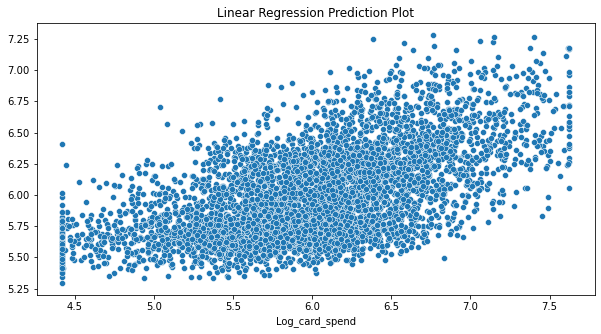

In [85]:
plt.figure(figsize=(10,5))
sns.scatterplot(Y,ols.predict(data_lr))
plt.title('Linear Regression Prediction Plot')
plt.show()

### 2. KNN

In [86]:
data_final.shape

(5000, 111)

In [87]:
# Standardization for KNN

In [88]:
standard_X=MinMaxScaler()

In [89]:
standard_X=standard_X.fit_transform(data_final)

In [90]:
standard_X=pd.DataFrame(standard_X,columns=data_final.columns)

In [91]:
standard_X.head()

,spousedcat_2,address,pets_small,agecat_5,spousedcat_3,ed,tenure,commutemotorcycle_1,card2tenure,cars_4,...,pets,carown_0,tollfree_1,pets_freshfish,townsize_4.0,tollten,card2type_2,cars_6,owncd_1,commutepublic_1
0,0.0,0.000000,0.0,0.0,0.0,0.529412,0.069444,1.0,0.100000,0.0,...,0.00,0.0,1.0,0.0,0.0,0.072754,0.0,0.0,0.0,0.0
1,0.0,0.037383,0.0,0.0,0.0,0.647059,0.541667,0.0,0.133333,0.0,...,0.48,0.0,0.0,0.6,0.0,0.000000,0.0,0.0,1.0,0.0
2,1.0,0.560748,0.0,0.0,0.0,0.470588,0.902778,0.0,0.833333,0.0,...,0.24,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,1.0,0.0
3,0.0,0.056075,0.0,0.0,0.0,0.588235,0.500000,0.0,0.166667,0.0,...,0.00,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,1.0,0.0
4,1.0,0.056075,0.0,0.0,0.0,0.588235,0.291667,0.0,0.300000,0.0,...,0.00,1.0,1.0,0.0,0.0,0.175143,0.0,0.0,1.0,1.0


In [92]:
standard_X.describe()

,spousedcat_2,address,pets_small,agecat_5,spousedcat_3,ed,tenure,commutemotorcycle_1,card2tenure,cars_4,...,pets,carown_0,tollfree_1,pets_freshfish,townsize_4.0,tollten,card2type_2,cars_6,owncd_1,commutepublic_1
count,5000.00000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.15780,0.306518,0.0,0.239000,0.101400,0.502529,0.530622,0.102600,0.436147,0.096200,...,0.243432,0.159800,0.475600,0.182140,0.171400,0.229723,0.24700,0.010200,0.932800,0.095400
std,0.36459,0.231514,0.0,0.426515,0.301888,0.193005,0.314748,0.303466,0.303980,0.294895,...,0.266633,0.366457,0.499454,0.299267,0.376896,0.336650,0.43131,0.100489,0.250393,0.293796
min,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.00000,0.112150,0.0,0.000000,0.000000,0.352941,0.250000,0.000000,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
50%,0.00000,0.261682,0.0,0.000000,0.000000,0.470588,0.527778,0.000000,0.400000,0.000000,...,0.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000
75%,0.00000,0.467290,0.0,0.000000,0.000000,0.647059,0.819444,0.000000,0.700000,0.000000,...,0.400000,0.000000,1.000000,0.400000,0.000000,0.400000,0.00000,0.000000,1.000000,0.000000
max,1.00000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [93]:
# #Train Test Split for KNN
# X_train_ml,X_test_ml,Y_train_ml,Y_test_ml=train_test_split(standard_X,Y,train_size=0.7,random_state=100)
# print(X_train_ml.shape)
# print(X_test_ml.shape)
# print(Y_train_ml.shape)
# print(Y_test_ml.shape)

In [94]:
params_knn={'n_neighbors':np.arange(2,40).tolist(),'weights':['uniform','distance']}

In [95]:
grid_knn=GridSearchCV(KNeighborsRegressor(),param_grid=params_knn,cv=5)

In [96]:
grid_knn=grid_knn.fit(standard_X,Y)

In [97]:
grid_knn.best_params_

{'n_neighbors': 33, 'weights': 'distance'}

In [98]:
grid_knn.best_score_

0.14409187539671706

In [99]:
knn=KNeighborsRegressor(n_neighbors=33,weights='distance')

In [100]:
knn=knn.fit(standard_X,Y)

In [101]:
knn_accuracy_score=metrics.r2_score(Y,knn.predict(standard_X))
print('knn_accuracy_score :',knn_accuracy_score)

knn_accuracy_score : 0.9999999999999872


In [102]:
knn_mape=metrics.mean_absolute_percentage_error(Y,knn.predict(standard_X))
print('KNN_mape :',knn_mape)

KNN_mape : 1.4937728267268948e-09


In [103]:
knn_mse=metrics.mean_squared_error(Y,knn.predict(standard_X))
print('KNN_mse :',knn_mse)

KNN_mse : 5.1561528328869945e-15


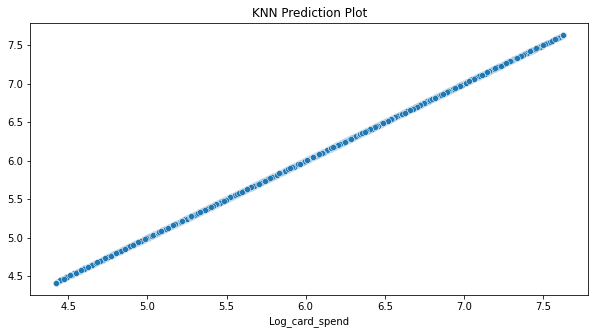

In [104]:
plt.figure(figsize=(10,5))
sns.scatterplot(Y,knn.predict(standard_X))
plt.title('KNN Prediction Plot')
plt.show()

### 3.Random Forest

In [105]:
# X_train_rf,X_test_rf,Y_train_rf,Y_test_rf=train_test_split(data_final,Y,train_size=0.7,random_state=100)
# print(X_train_rf.shape)
# print(X_test_rf.shape)
# print(Y_train_rf.shape)
# print(Y_test_rf.shape)

In [106]:
param_rf={'n_estimators':np.arange(0,400,50).tolist(),'max_depth': [5,10,15,20], 'max_features':[15,20,25]}

In [107]:
grid_rf=GridSearchCV(RandomForestRegressor(),param_grid=param_rf,cv=5,n_jobs=-1)

In [108]:
grid_rf=grid_rf.fit(standard_X,Y)

In [109]:
grid_rf.best_params_

{'max_depth': 20, 'max_features': 25, 'n_estimators': 250}

In [110]:
grid_rf.best_score_

0.21245149967946028

In [111]:
rf=RandomForestRegressor(random_state = 1, max_features= 25, n_estimators = 300, criterion='mse', max_depth=20)

In [112]:
rf=rf.fit(standard_X,Y)

In [113]:
metrics.r2_score(Y,rf.predict(standard_X))

0.8800275682195023

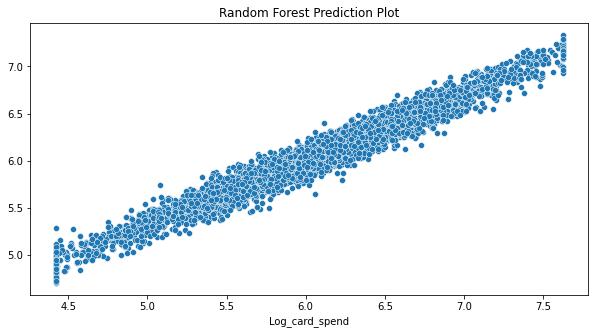

In [114]:
plt.figure(figsize=(10,5))
sns.scatterplot(Y,rf.predict(standard_X))
plt.title('Random Forest Prediction Plot')
plt.show()

### XGBOOST Regressor

In [115]:
xg=XGBRegressor()

In [116]:
xg=xg.fit(data_final,Y)

In [117]:
metrics.r2_score(Y,xg.predict(data_final))

0.9362119924193014

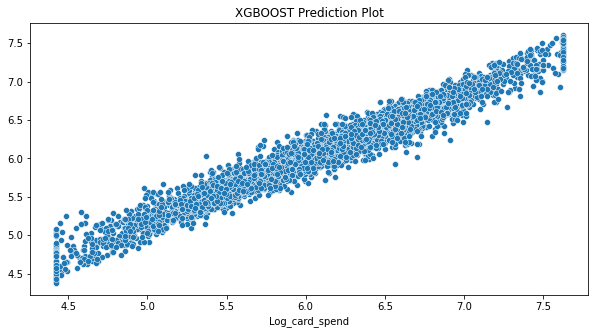

In [118]:
plt.figure(figsize=(10,5))
sns.scatterplot(Y,xg.predict(data_final))
plt.title('XGBOOST Prediction Plot')
plt.show()

In [119]:
pred_Y=np.exp(xg.predict(data_final))

In [120]:
data_final['original Y']=np.exp(Y)

In [121]:
data_final['Predicted Y']=pred_Y

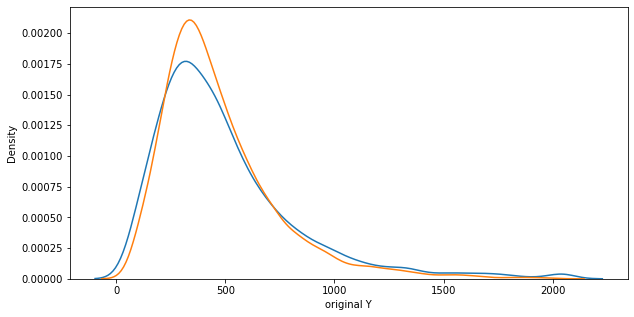

In [122]:
plt.figure(figsize=(10,5))
sns.kdeplot(data_final['original Y'])
sns.kdeplot(data_final['Predicted Y'])
plt.show()

# ----------END----------